In [1]:
import numpy as np
import pandas as pd
import glob
import emcee
import corner
import scipy.stats
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

from fit_just_early_lc import prep_light_curve

from multiprocessing import Pool
import time

from corner_hack import corner_hack
from light_curve_plot import f_t, plot_both_filt

In [2]:
%matplotlib notebook

In [3]:
info_path="../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype_pec.csv")
res = pd.read_csv('results_40percent.csv')

## Rise-Time constraints

In [4]:
bw_df = pd.read_csv('kde_bandwidths_uniformative.csv')
bw_df.rename(columns={'delta_bw':'ratio_bw'},  inplace=True)

In [17]:
pdf_array_tfl = np.zeros((len(res), 100000))
prop_unc_arr = np.zeros((len(res), 100000))

def get_pdf(tup):

    sn, bw = tup
    sn_num = np.where(salt_df.name == sn)[0]
    
    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 100
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    t_max_unc = salt_df.t0_g_adopted_unc.iloc[np.where(salt_df.name == sn)].values[0]

    t_grid = np.linspace(-25,-5,100000)
    t_fl_samples = samples[:,0]
    t_fl_data = np.reshape(t_fl_samples, (len(t_fl_samples), 1))

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(t_fl_data)

    pdf = kde.score_samples(t_grid.reshape(100000,1))
    
    prop_unc = gaussian_filter1d(np.exp(pdf), t_max_unc/(np.ptp(t_grid)/len(t_grid)),
                             mode='nearest')

    pdf_array_tfl[sn_num] = pdf
    prop_unc_arr[sn_num] = prop_unc
    
    return (pdf, prop_unc)

pool = Pool()

t_fl_res = pool.map(get_pdf, zip(bw_df.ztf_name.values, bw_df.tfl_bw.values))

In [18]:
t_grid = np.linspace(-25,-5,100000)

pdf_array_tfl = np.array(t_fl_res)[:,0]
prop_unc_arr = np.array(t_fl_res)[:,1]

norm_likelihood = np.sum(prop_unc_arr, axis=1)/len(t_grid)*np.ptp(t_grid)
norm_pdf_array = np.log(prop_unc_arr) - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(t_grid), axis=1)

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [19]:
mean_fl = np.sum(norm_pdf_array, axis=0)

norm_mean = np.sum(np.exp(mean_fl - np.max(mean_fl)))/len(t_grid)*np.ptp(t_grid)
mean_pdf_tfl = mean_fl - np.max(mean_fl) - np.repeat(np.log(norm_mean), len(t_grid))

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


In [14]:
normal = np.where((salt_df['Ia subtype'] != 'Ia-CSM') & 
                  (salt_df['Ia subtype'] != 'SC') & 
                  (salt_df['Ia subtype'] != 'SC*') & 
                  (salt_df['Ia subtype'] != '86G-like') & 
                  (salt_df['Ia subtype'] != '02cx-like'))
good = np.where(res.final_selection.values == 1)
has_host_z = np.where(salt_df.z_source != 'Msl')

normal_good = np.intersect1d(normal, good)
normal_good_host = np.intersect1d(normal_good, has_host_z)

# rearange for plotting
normal_plot = np.setdiff1d(normal[0], normal_good)
normal_good_plot = np.setdiff1d(normal_good, normal_good_host)

In [15]:
# plotting dictionary
color_dict = {'orange': '#F0810F',
              'blueberry': '#063852',
              'dark navy': '#011A27'}

<IPython.core.display.Javascript object>


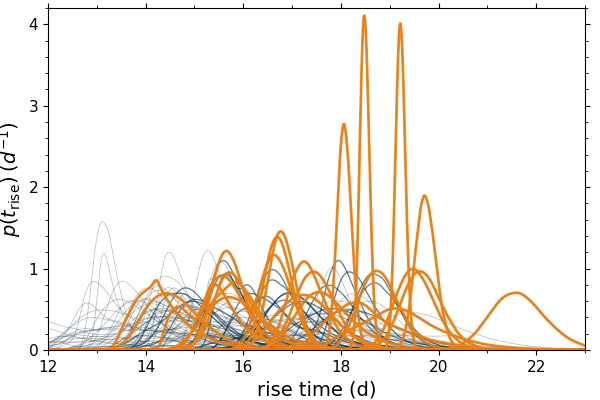

In [22]:
fig, ax = plt.subplots(figsize=(6,4))
for pdf_tfl in norm_pdf_array[normal]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf_tfl in norm_pdf_array[normal_good]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf_tfl in norm_pdf_array[normal_good_host]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            color=color_dict['orange'], lw=2, alpha=0.9)
    
# plt.plot(t_grid, mean_pdf_tfl, 'k', lw=1)
# plt.yscale('log')
ax.set_xlim(12,23)
ax.set_ylim(0,4.2)
ax.set_xlabel('rise time (d)',fontsize=14)
ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(right=True, top=True, bottom=True, which='both', labelsize=11)

fig.subplots_adjust(left=0.08,bottom=0.125,top=0.98,right=0.975)
fig.savefig('../paper/figures/rise_time.pdf')

<IPython.core.display.Javascript object>


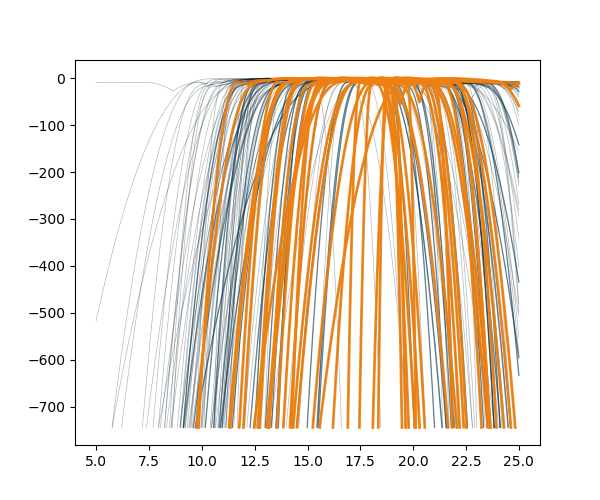

In [15]:
fig, ax = plt.subplots(figsize=(6,5))
for pdf_tfl in norm_pdf_array[normal]:
    ax.plot(-1*t_grid[::-1], pdf_tfl[::-1], 
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf_tfl in norm_pdf_array[normal_good]:
    ax.plot(-1*t_grid[::-1], pdf_tfl[::-1], 
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf_tfl in norm_pdf_array[normal_good_host]:
    ax.plot(-1*t_grid[::-1], pdf_tfl[::-1], 
            color=color_dict['orange'], lw=2, alpha=0.9)


In [16]:
low_z_good = np.where((salt_df['Ia subtype'] != 'Ia-CSM') & 
                      (salt_df['Ia subtype'] != 'SC') & 
                      (salt_df['Ia subtype'] != 'SC*') & 
                      (salt_df['Ia subtype'] != '86G-like') & 
                      (salt_df['Ia subtype'] != '02cx-like') & 
                      (res.final_selection.values == 1) & 
                      (salt_df.z_adopt < 0.06))

<IPython.core.display.Javascript object>


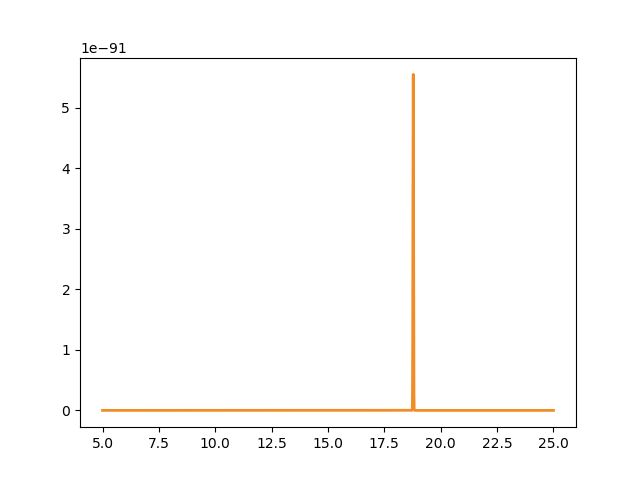

In [17]:
fig, ax = plt.subplots()

ax.plot(-1*t_grid[::-1], np.exp(np.sum(norm_pdf_array[low_z_good], axis=0))[::-1], 
            color=color_dict['orange'], lw=2, alpha=0.9)

## Get Rise Time Uncertainties

<IPython.core.display.Javascript object>


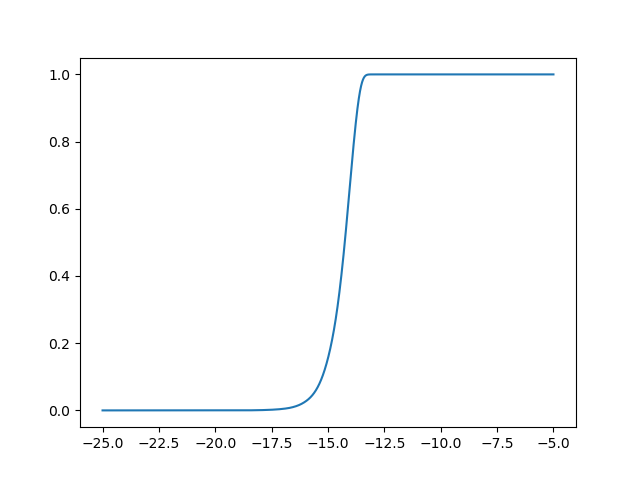

In [19]:
tmp_pdf = norm_pdf_array[0]
plt.figure()
plt.plot(t_grid, np.cumsum(np.exp(tmp_pdf))/len(t_grid)*np.ptp(t_grid))

In [20]:
t_rise_05 = np.zeros(len(res))
t_rise_16 = np.zeros_like(t_rise_05)
t_rise_50 = np.zeros_like(t_rise_05)
t_rise_84 = np.zeros_like(t_rise_05)
t_rise_95 = np.zeros_like(t_rise_05)

for sn_num, pdf in enumerate(norm_pdf_array):
    cum_prob = np.cumsum(np.exp(pdf)/len(t_grid)*np.ptp(t_grid))
    idx_05 = np.min(np.where(cum_prob > 0.05)[0])
    t_rise_95[sn_num] = -1*np.interp(0.05, cum_prob[idx_05-1:idx_05+1], t_grid[idx_05-1:idx_05+1])
    idx_16 = np.min(np.where(cum_prob > 0.15865)[0])
    t_rise_84[sn_num] = -1*np.interp(0.15865, cum_prob[idx_16-1:idx_16+1], t_grid[idx_16-1:idx_16+1])
    idx_50 = np.min(np.where(cum_prob > 0.5)[0])
    t_rise_50[sn_num] = -1*np.interp(0.50, cum_prob[idx_50-1:idx_50+1], t_grid[idx_50-1:idx_50+1])
    idx_84 = np.min(np.where(cum_prob > 0.84135)[0])
    t_rise_16[sn_num] = -1*np.interp(0.84135, cum_prob[idx_84-1:idx_84+1], t_grid[idx_84-1:idx_84+1])
    idx_95 = np.min(np.where(cum_prob > 0.95)[0])
    t_rise_05[sn_num] = -1*np.interp(0.95, cum_prob[idx_95-1:idx_95+1], t_grid[idx_95-1:idx_95+1])

In [21]:
res['t_rise_05'] = t_rise_05
res['t_rise_16'] = t_rise_16
res['t_rise_50'] = t_rise_50
res['t_rise_84'] = t_rise_84
res['t_rise_95'] = t_rise_95

res.to_csv('results_40percent.csv', index=False)

In [30]:
print('The following are summary statistics for rise time:')
print('mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(t_rise_50[normal]), np.median(t_rise_50[normal]),
                                                                   np.average(t_rise_50[normal], 
                                                                              weights=((t_rise_84[normal]-t_rise_16[normal])/2)**(-2))))
print('std, sMAD: {:.5f}, {:.5f}'.format(np.std(t_rise_50[normal], ddof=1), 
                                         1.4826*np.median(np.abs(t_rise_50[normal] - np.median(t_rise_50[normal])))))

print('  If you restrict to only "good" SNe however:')
print('    mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(t_rise_50[normal_good]), np.median(t_rise_50[normal_good]),
                                                                   np.average(t_rise_50[normal_good], 
                                                                              weights=((t_rise_84[normal_good]-t_rise_16[normal_good])/2)**(-2))))
print('    std, sMAD: {:.5f}, {:.5f}'.format(np.std(t_rise_50[normal_good], ddof=1), 
                                         1.4826*np.median(np.abs(t_rise_50[normal_good] - np.median(t_rise_50[normal_good])))))

print('\tFurther restrict to host-z SNe however:')
print('\t  mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(t_rise_50[normal_good_host]), np.median(t_rise_50[normal_good_host]),
                                                                   np.average(t_rise_50[normal_good_host], 
                                                                              weights=((t_rise_84[normal_good_host]-t_rise_16[normal_good_host])/2)**(-2))))
print('\t  std, sMAD: {:.5f}, {:.5f}'.format(np.std(t_rise_50[normal_good_host], ddof=1), 
                                         1.4826*np.median(np.abs(t_rise_50[normal_good_host] - np.median(t_rise_50[normal_good_host])))))


The following are summary statistics for rise time:
mean, median, weighted mean: 16.10438, 15.69945, 17.41140
std, sMAD: 1.80598, 1.99039
  If you restrict to only "good" SNe however:
    mean, median, weighted mean: 17.14282, 17.03089, 18.04998
    std, sMAD: 1.60406, 1.90093
	Further restrict to host-z SNe however:
	  mean, median, weighted mean: 17.42791, 17.29966, 18.29351
	  std, sMAD: 1.83456, 2.17756


## $\alpha_g$ constraints

In [23]:
alpha_grid = np.linspace(0,10,100000)

def get_pdf(tup):

    sn, bw = tup
    sn_num = np.where(salt_df.name == sn)[0]
    
    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 100
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    alpha_grid = np.linspace(0,10,100000)
    alpha_g_samples = samples[:,2]
    alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(alpha_g_data)

    pdf = kde.score_samples(alpha_grid.reshape(100000,1))
    
    return pdf

pool = Pool()

alpha_g_res = pool.map(get_pdf, zip(bw_df.ztf_name.values, bw_df.alpha_g_bw.values))

In [24]:
pdf_array_alpha_g = np.array(alpha_g_res)

# divide out the prior
div_prior = pdf_array_alpha_g + np.repeat(np.log(10)*alpha_grid.reshape(1,-1), 127, axis=0)

norm_likelihood = np.sum(np.exp(div_prior), axis=1)*(np.ptp(alpha_grid)/len(alpha_grid))
norm_pdf_array = div_prior - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(alpha_grid), axis=1)

<IPython.core.display.Javascript object>


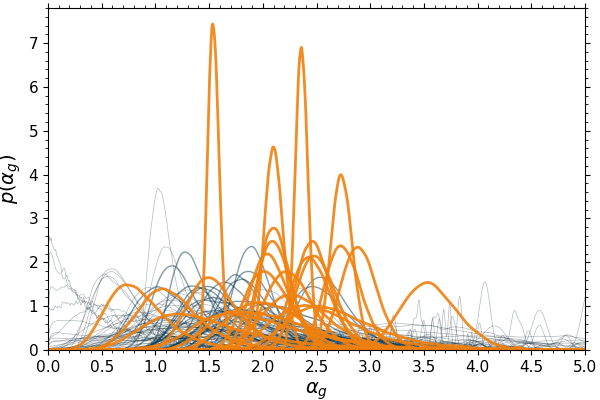

In [25]:
fig, ax = plt.subplots(figsize=(6,4))
for pdf in norm_pdf_array[normal_plot]:
    ax.plot(alpha_grid, np.exp(pdf),
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf in norm_pdf_array[normal_good_plot]:
    ax.plot(alpha_grid, np.exp(pdf),
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf in norm_pdf_array[normal_good_host]:
    ax.plot(alpha_grid, np.exp(pdf),
            color=color_dict['orange'], lw=2, alpha=0.9)

ax.set_xlim(0,5)
ax.set_ylim(0,7.8)
ax.set_xlabel(r'$\alpha_g$',fontsize=14)
ax.set_ylabel(r'$p(\alpha_g)$',fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(right=True, top=True, bottom=True, which='both', labelsize=11)

fig.subplots_adjust(left=0.08,bottom=0.125,top=0.98,right=0.975)
fig.savefig('../paper/figures/alpha_g.pdf')

In [42]:
flat_alpha_g_05 = np.zeros(len(res))
flat_alpha_g_16 = np.zeros_like(flat_alpha_g_05)
flat_alpha_g_50 = np.zeros_like(flat_alpha_g_05)
flat_alpha_g_84 = np.zeros_like(flat_alpha_g_05)
flat_alpha_g_95 = np.zeros_like(flat_alpha_g_05)

for sn_num, pdf in enumerate(norm_pdf_array):
    cum_prob = np.cumsum(np.exp(pdf)/len(alpha_grid)*np.ptp(alpha_grid))
    idx_05 = np.min(np.where(cum_prob > 0.05)[0])
    flat_alpha_g_95[sn_num] = np.interp(0.05, cum_prob[idx_05-1:idx_05+1], alpha_grid[idx_05-1:idx_05+1])
    idx_16 = np.min(np.where(cum_prob > 0.15865)[0])
    flat_alpha_g_84[sn_num] = np.interp(0.15865, cum_prob[idx_16-1:idx_16+1], alpha_grid[idx_16-1:idx_16+1])
    idx_50 = np.min(np.where(cum_prob > 0.5)[0])
    flat_alpha_g_50[sn_num] = np.interp(0.50, cum_prob[idx_50-1:idx_50+1], alpha_grid[idx_50-1:idx_50+1])
    idx_84 = np.min(np.where(cum_prob > 0.84135)[0])
    flat_alpha_g_16[sn_num] = np.interp(0.84135, cum_prob[idx_84-1:idx_84+1], alpha_grid[idx_84-1:idx_84+1])
    idx_95 = np.min(np.where(cum_prob > 0.95)[0])
    flat_alpha_g_05[sn_num] = np.interp(0.95, cum_prob[idx_95-1:idx_95+1], alpha_grid[idx_95-1:idx_95+1])

In [43]:
res['flat_alpha_g_05'] = flat_alpha_g_05
res['flat_alpha_g_16'] = flat_alpha_g_16
res['flat_alpha_g_50'] = flat_alpha_g_50
res['flat_alpha_g_84'] = flat_alpha_g_84
res['flat_alpha_g_95'] = flat_alpha_g_95

res.to_csv('results_40percent.csv', index=False)

In [44]:
print('The following are summary statistics for rise time:')
print('mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_g_50[normal]), np.median(flat_alpha_g_50[normal]),
                                                                   np.average(flat_alpha_g_50[normal], 
                                                                              weights=((flat_alpha_g_84[normal]-flat_alpha_g_16[normal])/2)**(-2))))
print('std, sMAD: {:.5f}, {:.5f}'.format(np.std(flat_alpha_g_50[normal], ddof=1), 
                                         1.4826*np.median(np.abs(flat_alpha_g_50[normal] - np.median(flat_alpha_g_50[normal])))))

print('  If you restrict to only "good" SNe however:')
print('    mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_g_50[normal_good]), np.median(flat_alpha_g_50[normal_good]),
                                                                   np.average(flat_alpha_g_50[normal_good], 
                                                                              weights=((flat_alpha_g_84[normal_good]-flat_alpha_g_16[normal_good])/2)**(-2))))
print('    std, sMAD: {:.5f}, {:.5f}'.format(np.std(flat_alpha_g_50[normal_good], ddof=1), 
                                         1.4826*np.median(np.abs(flat_alpha_g_50[normal_good] - np.median(flat_alpha_g_50[normal_good])))))

print('\tFurther restrict to host-z SNe however:')
print('\t  mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_g_50[normal_good_host]), np.median(flat_alpha_g_50[normal_good_host]),
                                                                   np.average(flat_alpha_g_50[normal_good_host], 
                                                                              weights=((flat_alpha_g_84[normal_good_host]-flat_alpha_g_16[normal_good_host])/2)**(-2))))
print('\t  std, sMAD: {:.5f}, {:.5f}'.format(np.std(flat_alpha_g_50[normal_good_host], ddof=1), 
                                         1.4826*np.median(np.abs(flat_alpha_g_50[normal_good_host] - np.median(flat_alpha_g_50[normal_good_host])))))


The following are summary statistics for rise time:
mean, median, weighted mean: 1.85714, 1.86430, 1.89465
std, sMAD: 0.74960, 0.69332
  If you restrict to only "good" SNe however:
    mean, median, weighted mean: 1.99484, 2.04070, 2.05299
    std, sMAD: 0.53178, 0.60061
	Further restrict to host-z SNe however:
	  mean, median, weighted mean: 2.16909, 2.11633, 2.11978
	  std, sMAD: 0.58515, 0.52788


##  $\alpha_r$ constraints

In [5]:
alpha_grid = np.linspace(0,10,100000)

def get_pdf(tup):

    sn, bw = tup
    sn_num = np.where(salt_df.name == sn)[0]
    
    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 100
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    alpha_grid = np.linspace(0,10,100000)
    alpha_r_samples = samples[:,4]
    alpha_r_data = np.reshape(alpha_r_samples, (len(alpha_r_samples), 1))

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(alpha_r_data)

    pdf = kde.score_samples(alpha_grid.reshape(100000,1))
    
    
    return pdf

pool = Pool()

alpha_r_res = pool.map(get_pdf, zip(bw_df.ztf_name.values, bw_df.alpha_r_bw.values))

In [6]:
pdf_array_alpha_r = np.array(alpha_r_res)

# divide out the prior
div_prior = pdf_array_alpha_r + np.repeat(np.log(10)*alpha_grid.reshape(1,-1), 127, axis=0)

norm_likelihood = np.sum(np.exp(div_prior), axis=1)/len(alpha_grid)*np.ptp(alpha_grid)
norm_pdf_array = div_prior - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(alpha_grid), axis=1)

<IPython.core.display.Javascript object>


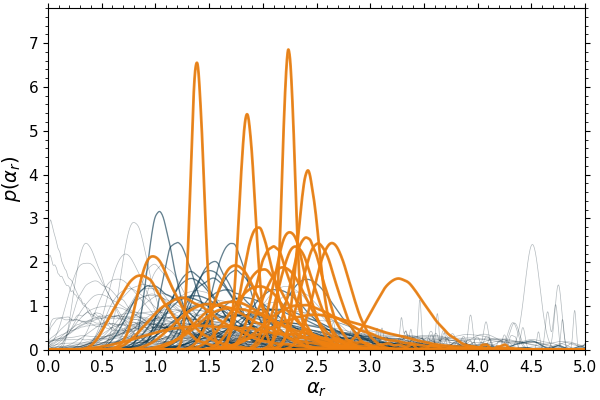

In [13]:
fig, ax = plt.subplots(figsize=(6,4))
for pdf in norm_pdf_array[normal]:
    ax.plot(alpha_grid, np.exp(pdf),
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf in norm_pdf_array[normal_good]:
    ax.plot(alpha_grid, np.exp(pdf),
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf in norm_pdf_array[normal_good_host]:
    ax.plot(alpha_grid, np.exp(pdf),
            color=color_dict['orange'], lw=2, alpha=0.9)

    
ax.set_xlim(0,5)
ax.set_ylim(0,7.8)
ax.set_xlabel(r'$\alpha_r$',fontsize=14)
ax.set_ylabel(r'$p(\alpha_r)$',fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(right=True, top=True, bottom=True, which='both', labelsize=11)

fig.subplots_adjust(left=0.08,bottom=0.125,top=0.98,right=0.975)
fig.savefig('../paper/figures/alpha_r.pdf')

In [14]:
flat_alpha_r_05 = np.zeros(len(res))
flat_alpha_r_16 = np.zeros_like(flat_alpha_r_05)
flat_alpha_r_50 = np.zeros_like(flat_alpha_r_05)
flat_alpha_r_84 = np.zeros_like(flat_alpha_r_05)
flat_alpha_r_95 = np.zeros_like(flat_alpha_r_05)

for sn_num, pdf in enumerate(norm_pdf_array):
    cum_prob = np.cumsum(np.exp(pdf)/len(alpha_grid)*np.ptp(alpha_grid))
    idx_05 = np.min(np.where(cum_prob > 0.05)[0])
    flat_alpha_r_95[sn_num] = np.interp(0.05, cum_prob[idx_05-1:idx_05+1], alpha_grid[idx_05-1:idx_05+1])
    idx_16 = np.min(np.where(cum_prob > 0.15865)[0])
    flat_alpha_r_84[sn_num] = np.interp(0.15865, cum_prob[idx_16-1:idx_16+1], alpha_grid[idx_16-1:idx_16+1])
    idx_50 = np.min(np.where(cum_prob > 0.5)[0])
    flat_alpha_r_50[sn_num] = np.interp(0.50, cum_prob[idx_50-1:idx_50+1], alpha_grid[idx_50-1:idx_50+1])
    idx_84 = np.min(np.where(cum_prob > 0.84135)[0])
    flat_alpha_r_16[sn_num] = np.interp(0.84135, cum_prob[idx_84-1:idx_84+1], alpha_grid[idx_84-1:idx_84+1])
    idx_95 = np.min(np.where(cum_prob > 0.95)[0])
    flat_alpha_r_05[sn_num] = np.interp(0.95, cum_prob[idx_95-1:idx_95+1], alpha_grid[idx_95-1:idx_95+1])

In [15]:
res['flat_alpha_r_05'] = flat_alpha_r_05
res['flat_alpha_r_16'] = flat_alpha_r_16
res['flat_alpha_r_50'] = flat_alpha_r_50
res['flat_alpha_r_84'] = flat_alpha_r_84
res['flat_alpha_r_95'] = flat_alpha_r_95

res.to_csv('results_40percent.csv', index=False)

In [16]:
print('The following are summary statistics for rise time:')
print('mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_r_50[normal]), np.median(flat_alpha_r_50[normal]),
                                                                   np.average(flat_alpha_r_50[normal], 
                                                                              weights=((flat_alpha_r_84[normal]-flat_alpha_r_16[normal])/2)**(-2))))
print('std, sMAD: {:.5f}, {:.5f}'.format(np.std(flat_alpha_r_50[normal], ddof=1), 
                                         1.4826*np.median(np.abs(flat_alpha_r_50[normal] - np.median(flat_alpha_r_50[normal])))))

print('  If you restrict to only "good" SNe however:')
print('    mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_r_50[normal_good]), np.median(flat_alpha_r_50[normal_good]),
                                                                   np.average(flat_alpha_r_50[normal_good], 
                                                                              weights=((flat_alpha_r_84[normal_good]-flat_alpha_r_16[normal_good])/2)**(-2))))
print('    std, sMAD: {:.5f}, {:.5f}'.format(np.std(flat_alpha_r_50[normal_good], ddof=1), 
                                         1.4826*np.median(np.abs(flat_alpha_r_50[normal_good] - np.median(flat_alpha_r_50[normal_good])))))

print('\tFurther restrict to host-z SNe however:')
print('\t  mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_r_50[normal_good_host]), np.median(flat_alpha_r_50[normal_good_host]),
                                                                   np.average(flat_alpha_r_50[normal_good_host], 
                                                                              weights=((flat_alpha_r_84[normal_good_host]-flat_alpha_r_16[normal_good_host])/2)**(-2))))
print('\t  std, sMAD: {:.5f}, {:.5f}'.format(np.std(flat_alpha_r_50[normal_good_host], ddof=1), 
                                         1.4826*np.median(np.abs(flat_alpha_r_50[normal_good_host] - np.median(flat_alpha_r_50[normal_good_host])))))


The following are summary statistics for rise time:
mean, median, weighted mean: 1.75008, 1.65442, 1.73165
std, sMAD: 0.79953, 0.82024
  If you restrict to only "good" SNe however:
    mean, median, weighted mean: 1.88306, 1.85717, 1.89450
    std, sMAD: 0.50188, 0.56953
	Further restrict to host-z SNe however:
	  mean, median, weighted mean: 2.03314, 2.02495, 1.99010
	  std, sMAD: 0.53646, 0.44773


## $\alpha_g/\alpha_r$

In [11]:
delta_grid = np.linspace(-4,4,100000)

def get_pdf(tup):

    sn, bw = tup
    sn_num = np.where(salt_df.name == sn)[0]
    
#     h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
#     reader = emcee.backends.HDFBackend(h5_file)
#     thin_by = 100
#     nsteps = thin_by*np.shape(reader.get_chain())[0]
#     tau = reader.get_autocorr_time(tol=0)
#     burnin = int(5*np.max(tau))
#     samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    delta_df = pd.read_hdf(info_path + 'big_unc/{}_uninformative_deltas.h5'.format(sn))
    delta = delta_df.delta.values   

    delta_grid = np.linspace(-4,4,100000)
    delta_data = np.reshape(delta, (len(delta), 1))

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(delta_data)

    pdf = kde.score_samples(delta_grid.reshape(100000,1))
    
    
    return pdf

pool = Pool()

ratio_res = pool.map(get_pdf, zip(bw_df.ztf_name.values, bw_df.ratio_bw.values))

In [12]:
pdf_array_ratio = np.array(ratio_res)

# divide out the prior
div_prior = pdf_array_ratio + np.repeat(np.log(10)*ratio_grid.reshape(1,-1), 127, axis=0)

norm_likelihood = np.sum(np.exp(div_prior), axis=1)/len(ratio_grid)*np.ptp(ratio_grid)
norm_pdf_array = div_prior - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(ratio_grid), axis=1)

<IPython.core.display.Javascript object>


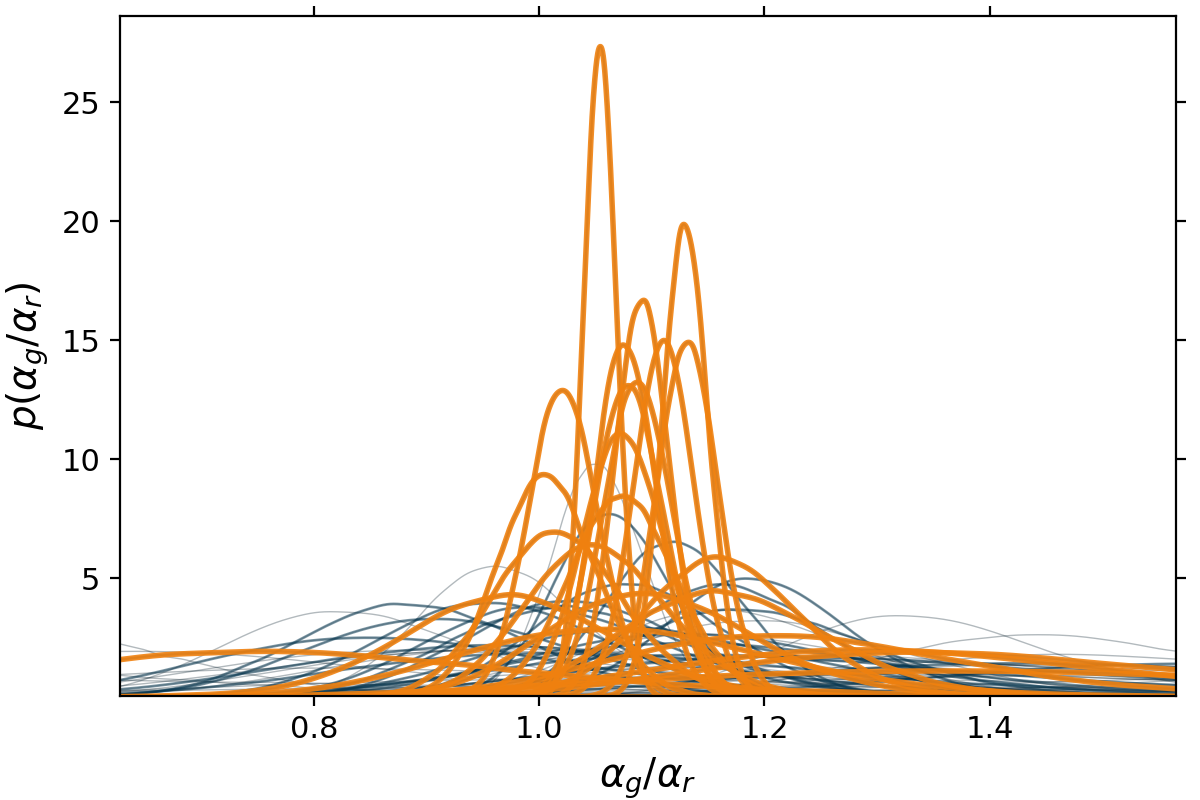

In [24]:
fig, ax = plt.subplots(figsize=(6,4))
for pdf in norm_pdf_array[normal]:
    ax.plot(ratio_grid, np.exp(pdf),
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf in norm_pdf_array[normal_good]:
    ax.plot(ratio_grid, np.exp(pdf),
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf in norm_pdf_array[normal_good_host]:
    ax.plot(ratio_grid, np.exp(pdf),
            color=color_dict['orange'], lw=2, alpha=0.9)

    
ax.set_xlim(0,3)
ax.set_ylim(0,30)
ax.set_xlabel(r'$\alpha_g/\alpha_r$',fontsize=14)
ax.set_ylabel(r'$p(\alpha_g/\alpha_r)$',fontsize=14)

# ax.xaxis.set_minor_locator(MultipleLocator(0.1))
# ax.xaxis.set_major_locator(MultipleLocator(0.5))
# ax.yaxis.set_minor_locator(MultipleLocator(0.2))
# ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(right=True, top=True, bottom=True, which='both', labelsize=11)

fig.subplots_adjust(left=0.1,bottom=0.13,top=0.98,right=0.98)
fig.savefig('../paper/figures/ratio.pdf')

In [49]:
mean_delta = np.sum(norm_pdf_array[normal_good_host], axis=0)

norm_mean = np.sum(np.exp(mean_delta))/len(delta_grid)*np.ptp(delta_grid)
mean_pdf_delta = mean_delta - np.repeat(np.log(norm_mean), len(delta_grid))

<IPython.core.display.Javascript object>


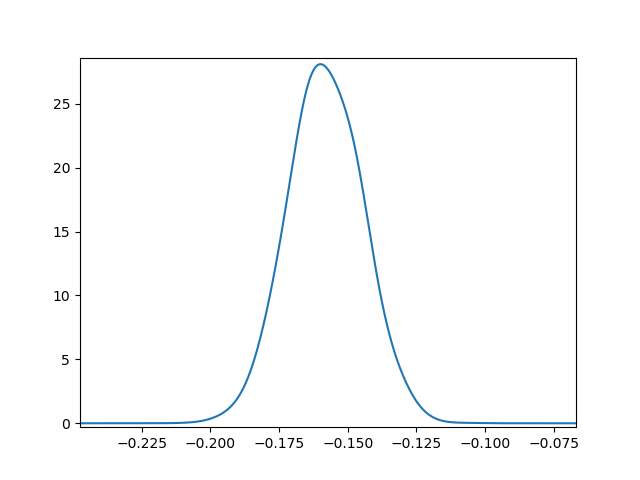

In [50]:
plt.figure()
plt.plot(delta_grid, np.exp(mean_pdf_delta))

### Drawing from a 2D distribution to get $\alpha_r - \alpha_g$


The example for drawing from the 2d posterior $\longrightarrow$ likelihood to get $\alpha_r - \alpha_g$. This has been scripted, and results for the full population are shown above. (The below cells show an example for a single variate)

In [177]:
# sn = 'ZTF18aazabmh'
sn = 'ZTF18abauprj'
sn_num = np.where(salt_df.name == sn)[0]

h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
thin_by = 100
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)
burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

In [178]:
X = samples[:,(2,4)]

kde = KernelDensity(rtol=1e-4, bandwidth=0.03)

kde.fit(X)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.03, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0.0001)

In [179]:
xx, yy = np.mgrid[0:7.5:0.0075, 
                  0:7.5:0.0075]

xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

In [180]:
z = kde.score_samples(xy_sample)

In [181]:
zz = np.reshape(z, xx.shape)

<IPython.core.display.Javascript object>


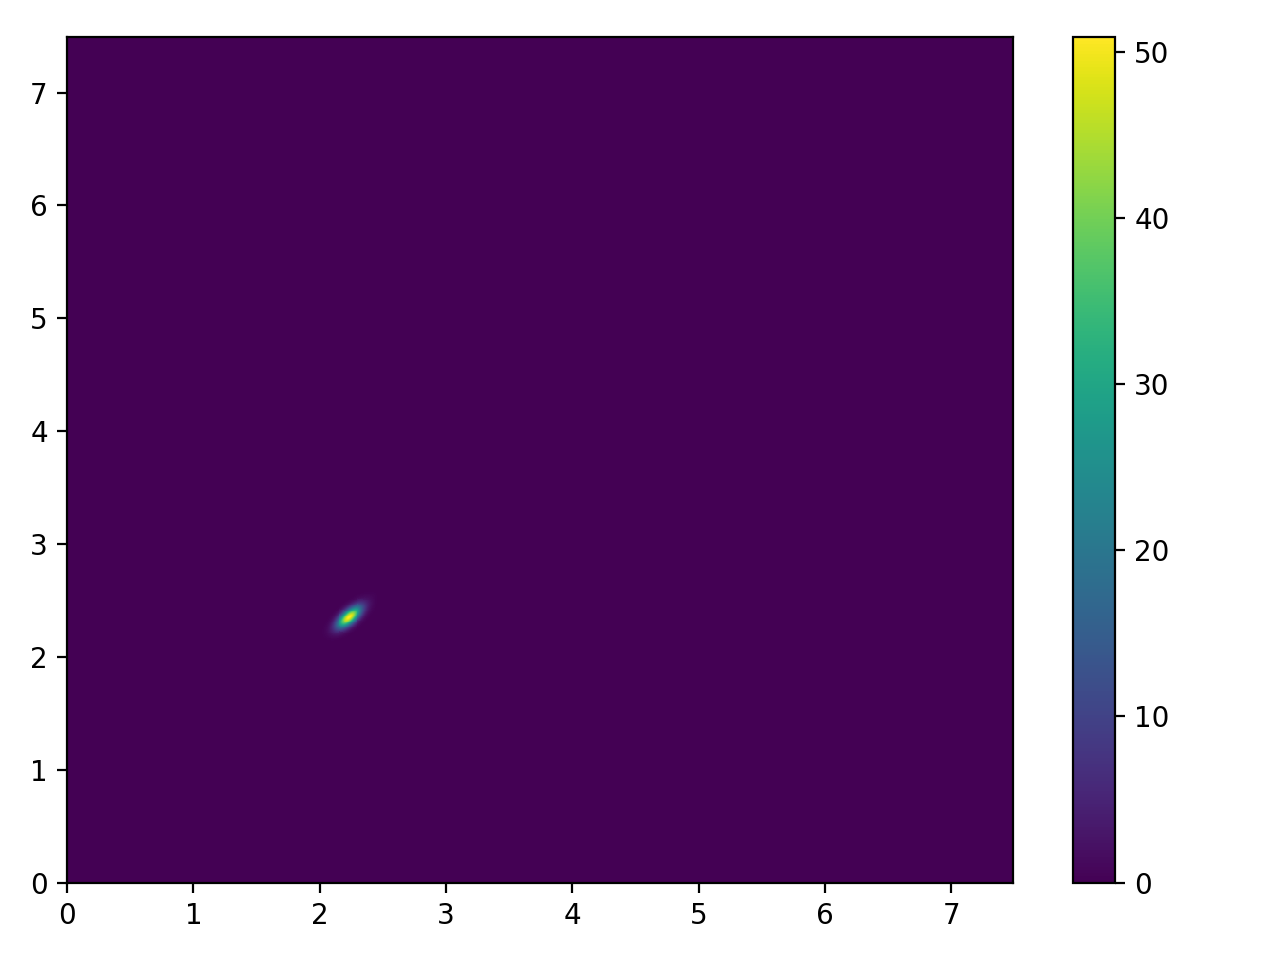

In [182]:
plt.figure()
plt.pcolormesh(xx,yy,np.exp(zz))
# plt.ylim(2.1,2.6)
# plt.xlim(2.1,2.6)
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


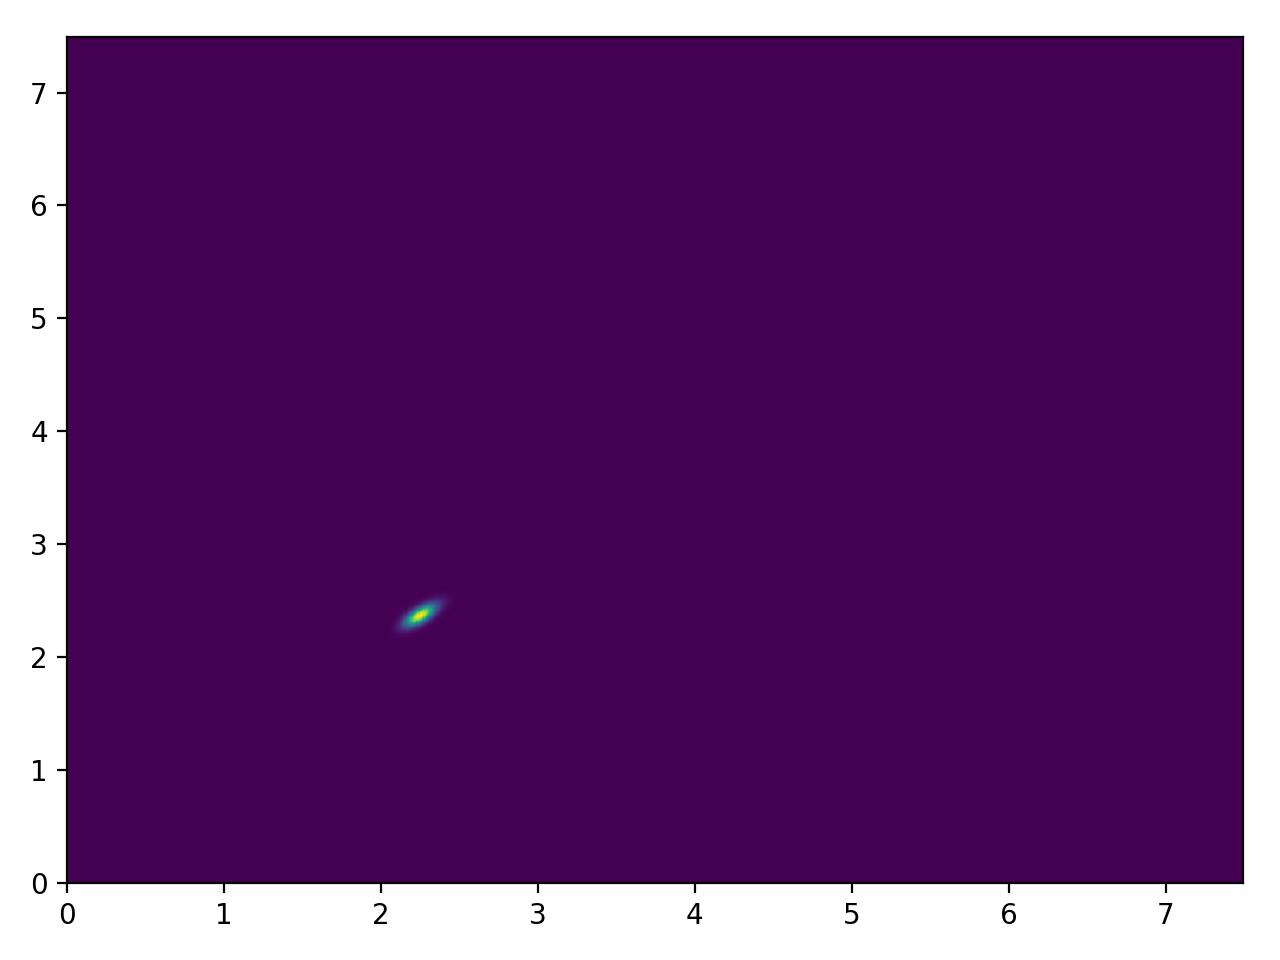

In [187]:
plt.figure()
plt.pcolormesh(xx, yy, np.exp(zz)*10**(xx+yy))
# plt.ylim(2.1,2.6)
# plt.xlim(2.1,2.6)
plt.tight_layout()

<IPython.core.display.Javascript object>


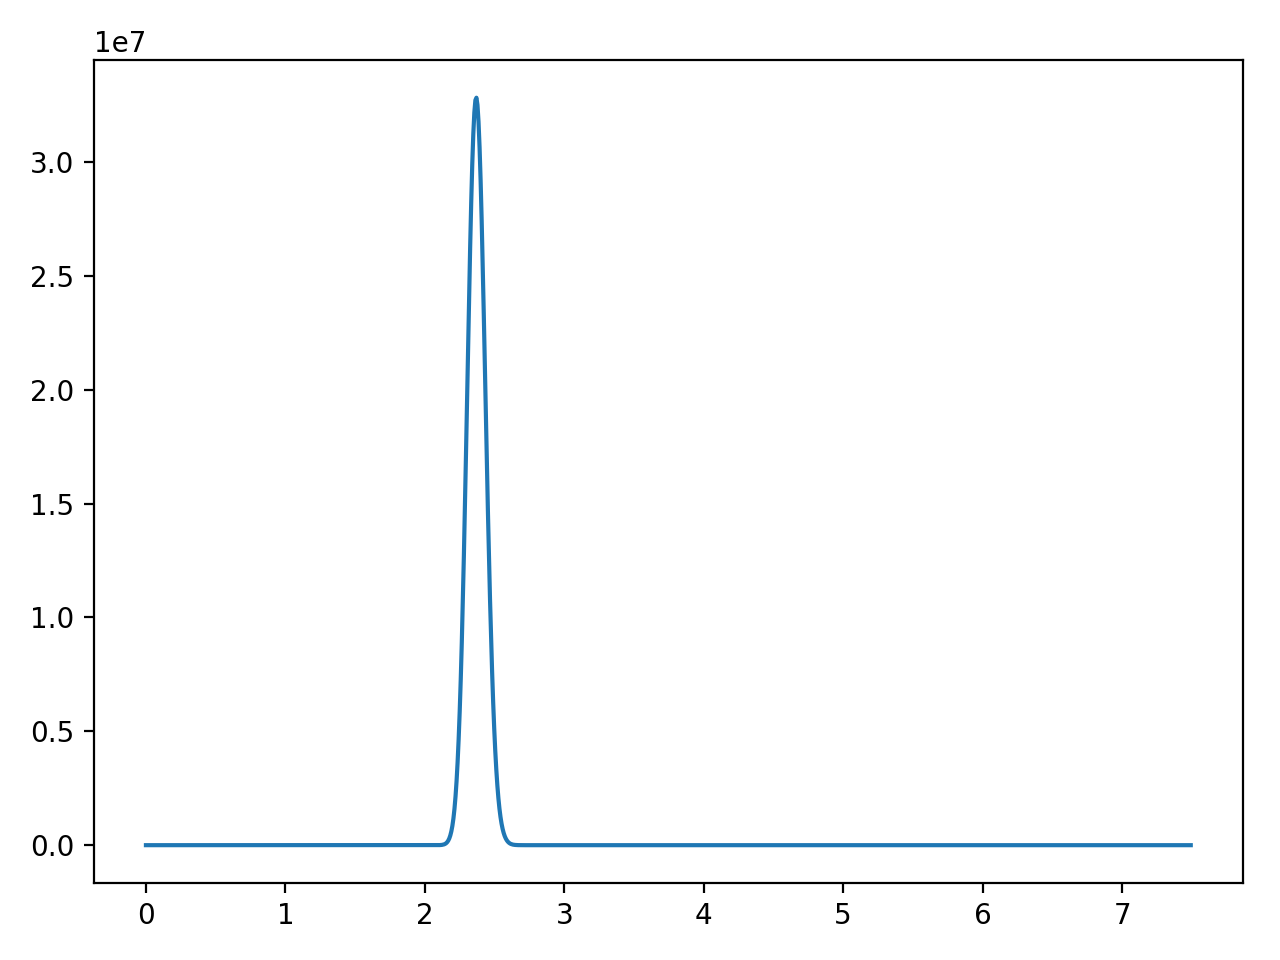

In [188]:
# collapse everything along x-axis
plt.figure()
plt.plot(xx[:,0], np.sum(np.exp(zz)*10**(xx+yy), axis=0)) # sum along x-axis
plt.tight_layout()

<IPython.core.display.Javascript object>


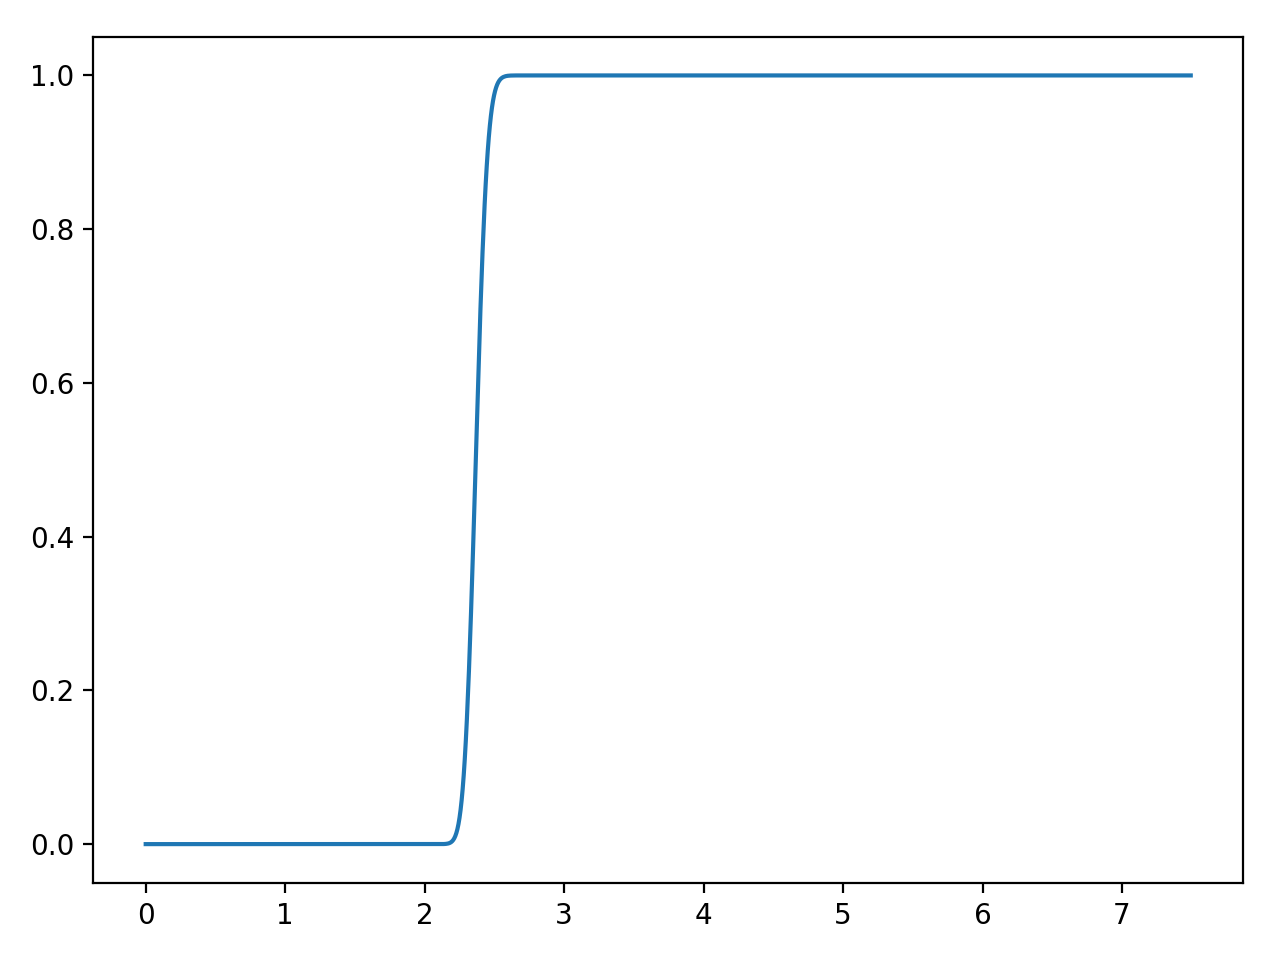

In [189]:
plt.figure()
cdf = np.cumsum(np.sum(np.exp(zz)*10**(xx+yy), axis=0))
plt.plot(xx[:,0], cdf/cdf[-1]) # sum along x-axis
plt.tight_layout()

In [190]:
rand_uni = np.random.uniform(size=len(samples))
alpha_g = np.interp(rand_uni, cdf/cdf[-1], xx[:,0])

<IPython.core.display.Javascript object>


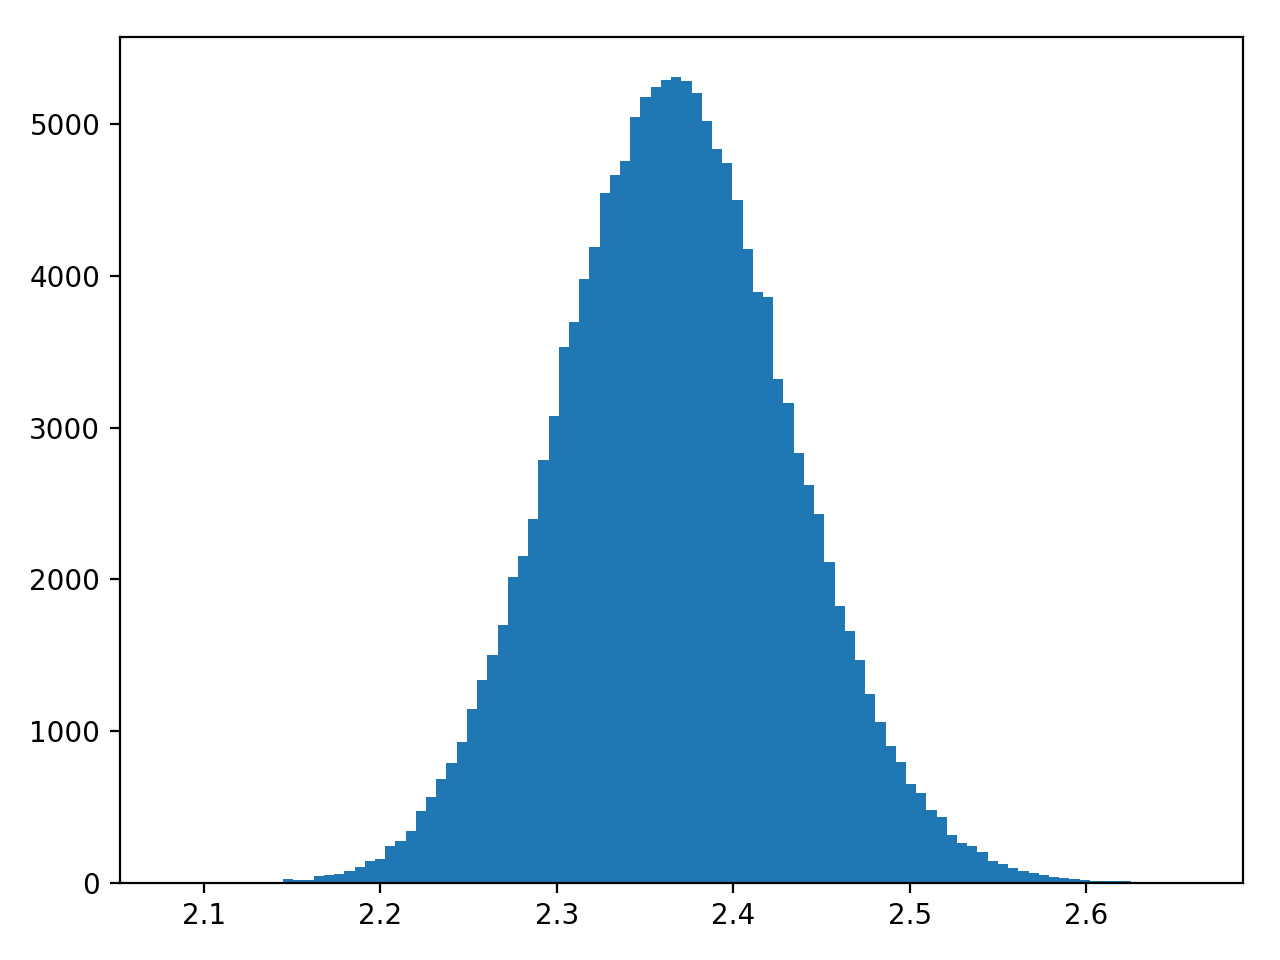

In [192]:
plt.figure()
_ = plt.hist(alpha_g, bins=100)
plt.tight_layout()

In [193]:
from scipy.interpolate import RectBivariateSpline

f = RectBivariateSpline(xx[:,0], yy[0], np.exp(zz)*10**(xx+yy))

In [194]:
alpha_g[0]

2.3223062984576934

In [195]:
haha = f(yy[0], alpha_g[0])

<IPython.core.display.Javascript object>


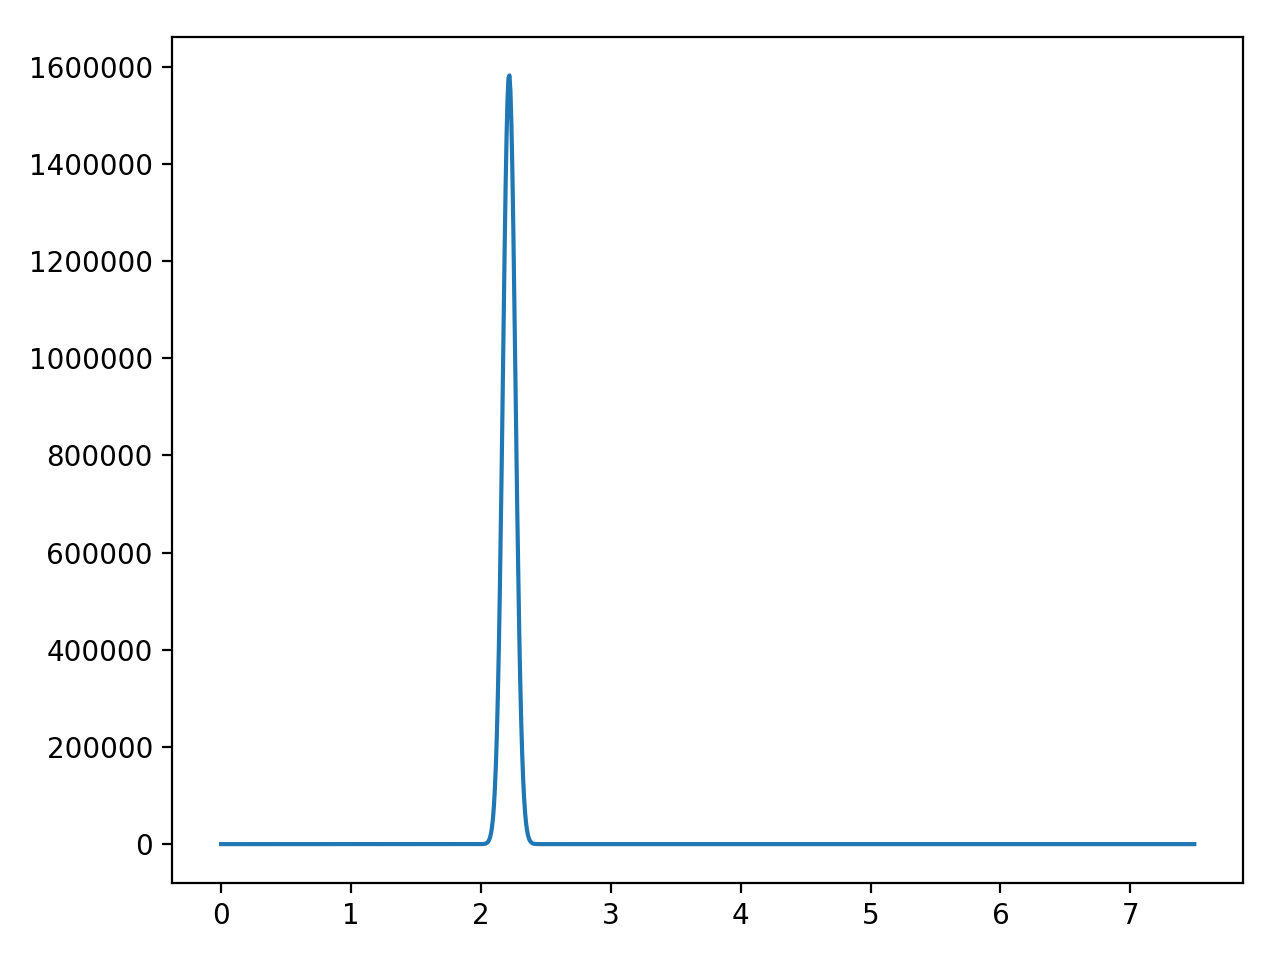

In [197]:
plt.figure()
plt.plot(yy[0], haha[:,0])
plt.tight_layout()

<IPython.core.display.Javascript object>


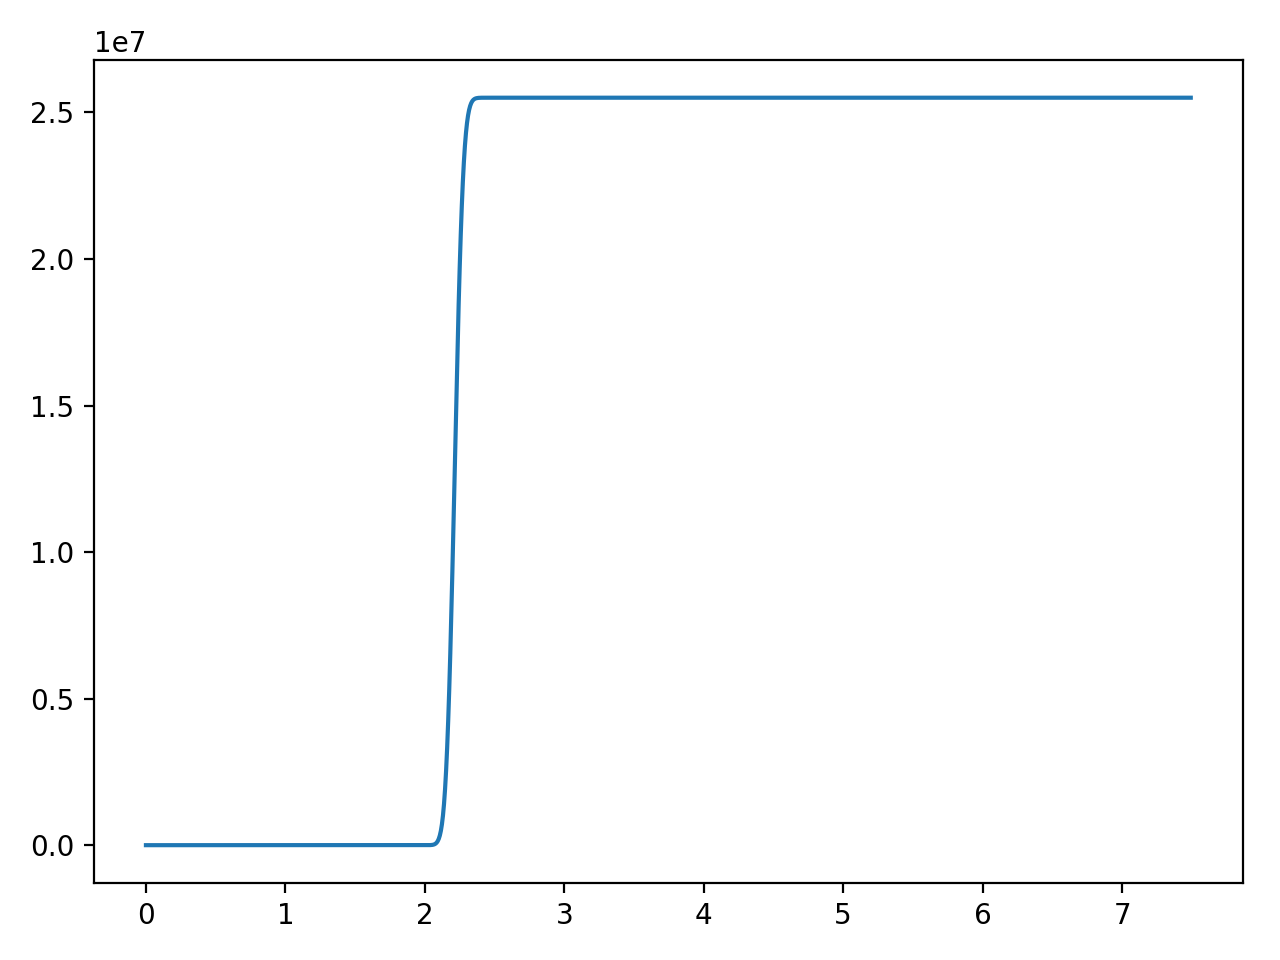

In [198]:
cdf_alpha_r = np.cumsum(haha[:,0])

plt.figure()
plt.plot(yy[0], cdf_alpha_r)
plt.tight_layout()

In [199]:
rand_num = np.random.uniform()
alpha_r = np.interp(rand_num, cdf_alpha_r/cdf_alpha_r[-1], yy[0])

In [200]:
alpha_r

2.0906511515148996

In [201]:
# loop to get all the alpha_r

alpha_r = np.zeros_like(alpha_g)

for al_num, al in enumerate(alpha_g):
    pdf_r = f(yy[0], al)
    cdf_r = np.cumsum(pdf_r[:,0])
    rand_num = np.random.uniform()
    alpha_r[al_num] = np.interp(rand_num, cdf_r/cdf_r[-1], yy[0])

<IPython.core.display.Javascript object>


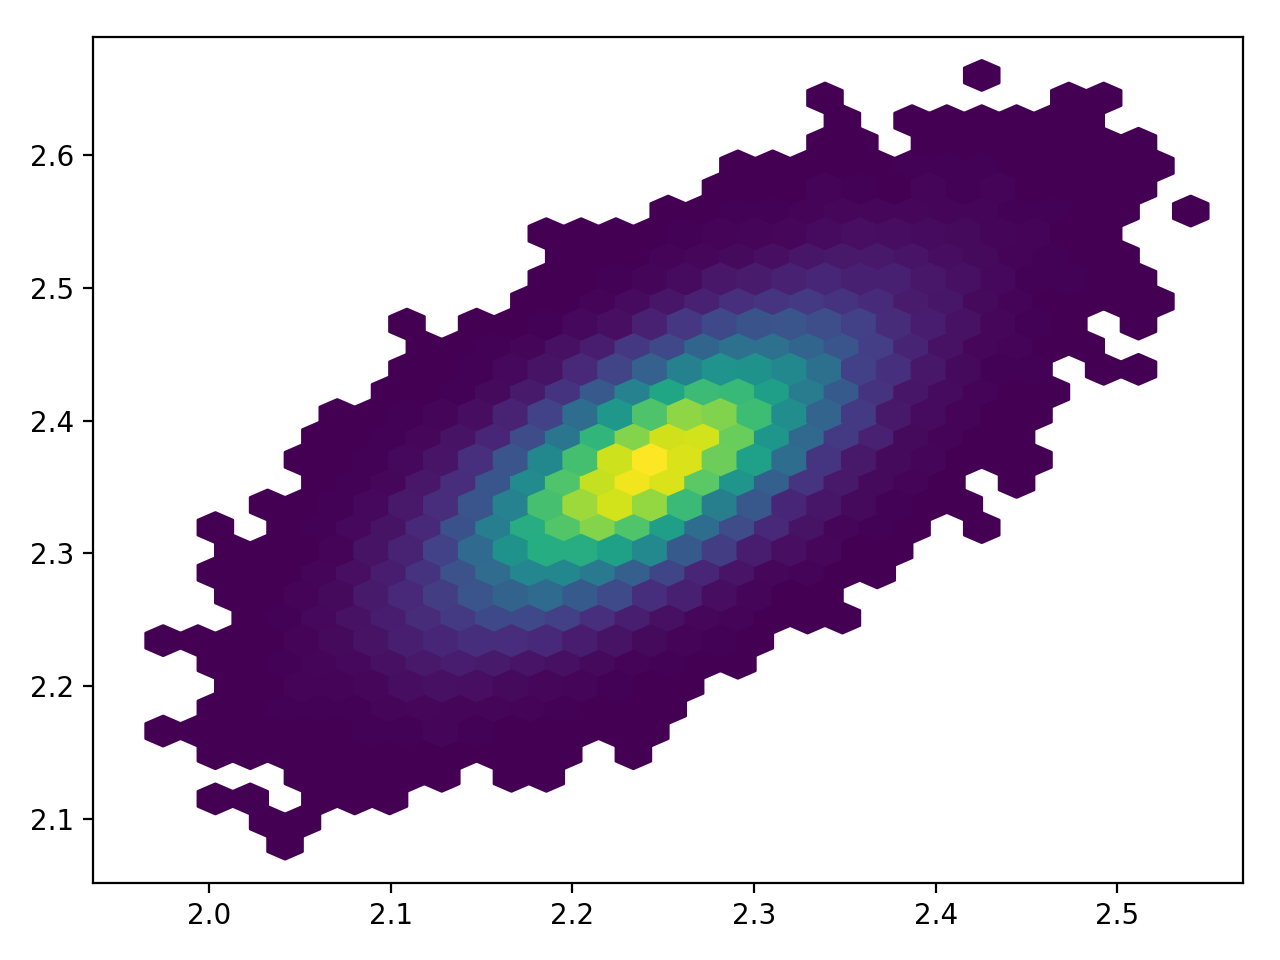

In [203]:
plt.figure()
plt.hexbin(alpha_r,alpha_g, gridsize=30, mincnt=1)
plt.tight_layout()

<IPython.core.display.Javascript object>


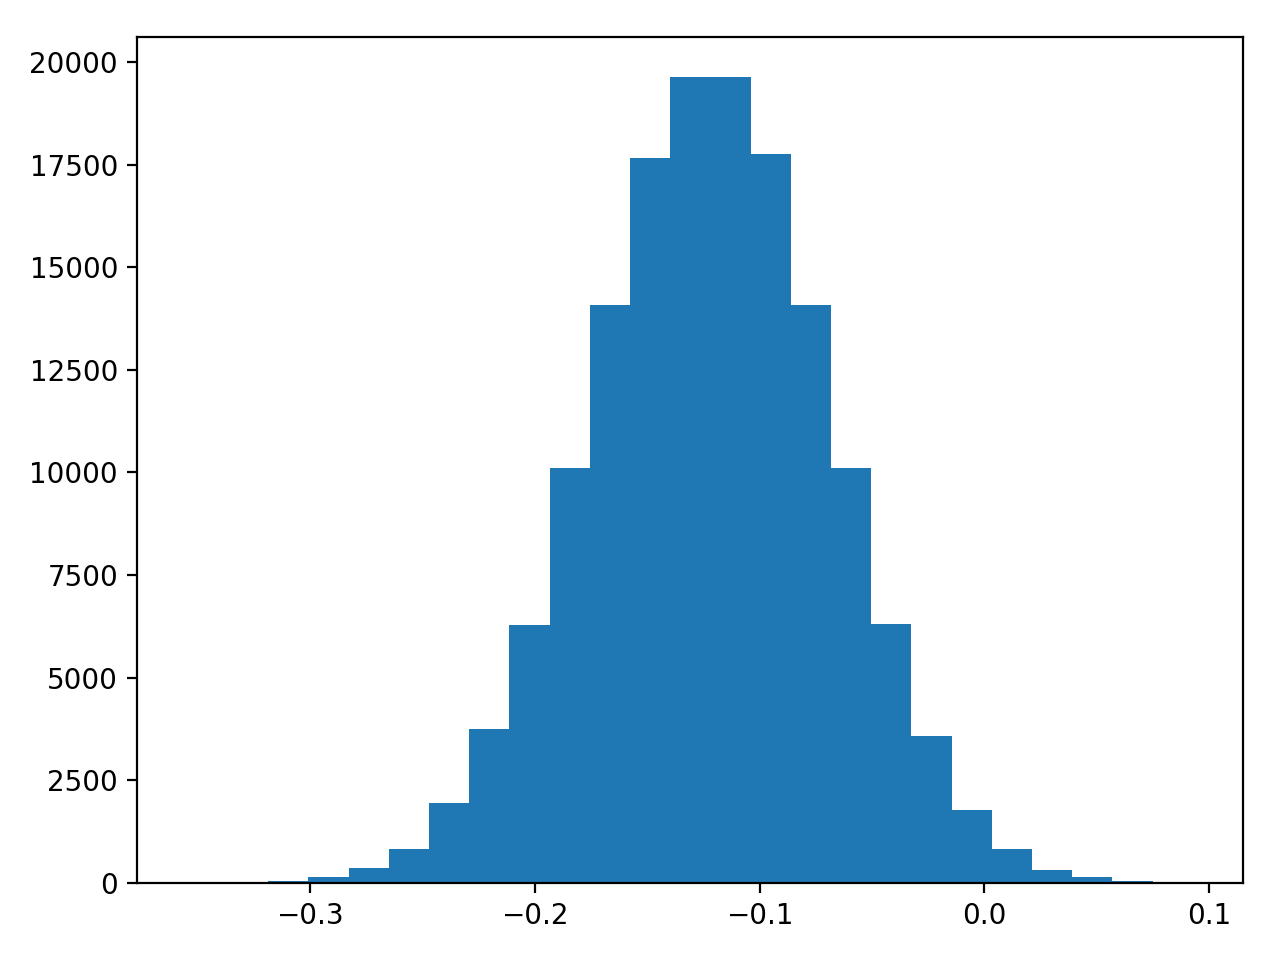

In [204]:
plt.figure()
plt.hist(alpha_r - alpha_g, bins=25)
plt.tight_layout()

In [205]:
delta = alpha_r - alpha_g
delta_df = pd.DataFrame(delta, columns=['delta'])